In [1]:
#set plots to show inline
%matplotlib inline

#import necessary libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pathlib
import processing_pypeline.readScanM as rsm
import napari
import igorwriter
#from igor import binarywave

from scanmsupport.scanm.scanm_smp import SMP, SMH

# Give path

In [2]:
path = r"D:\Igor analyses\230613\0_1_ColorSWN_200_0.smp"
path = r"C:\Users\simen\Downloads\Real large boi 2\0_2_ColorSWN_200_0.smh"

# Load data (new method)

In [174]:
def build_wParams(initialised_SMP_object):
    # Build wParamsNum and wParamsStr
    keys = initialised_SMP_object._kvPairDict.keys() 
    AllParams = [(i, initialised_SMP_object._kvPairDict[i]) for i in scmf._kvPairDict]
    AllParams_arr = np.array(AllParams, dtype = object)
    # Get all info for wParamsStr and compile two lits (list lables and list values)
    guid = scmf.GUID # no clue what this is but is included in wParamsStr
    wParamsStr_labels = ["ComputerName", "UserName", "OriginalPixelDataFileName", "DateStamp", 
    "TimeStamp", "ScanMproductVersionAndTargetOS", "CallingProcessPath", "CallingProcessVersion",
    "StimBufLenList", "TargetedStimDurList", "TargetedStimDurList", "InChan_PixBufLenList", 
    "ScanPathFunc", "IgorGUIVer", "Comment", "Objective", "RealStimDurList"]
    wParamsStr_vals = [str(f'"{initialised_SMP_object._kvPairDict[i][2]}"') for i in wParamsStr_labels]
    # Go through and clean up all indeces so they match current IGOR implementation
    wParamsStr_vals[0]  = wParamsStr_vals[0].upper()
    wParamsStr_vals[1]  = wParamsStr_vals[1].upper()
    wParamsStr_vals[9]  = wParamsStr_vals[9].replace("[", "").replace("]", "").replace(" ", ";").replace(".", "")
    wParamsStr_vals[10] = wParamsStr_vals[10].replace("[", "").replace("]", "").replace(" ", ";").replace(".", "")
    wParamsStr_vals[11] = wParamsStr_vals[11].replace("[", "").replace("]", "").replace(" ", ";").replace(".", "")
    wParamsStr_vals[12] = wParamsStr_vals[12].replace("[", "").replace("]", "").replace(" ", "").replace(",", "").replace("'", "|").replace("||", "|")
    wParamsStr_vals[16] = wParamsStr_vals[16].replace("[", "").replace("]", "").replace(" ", ";").replace(".", "")
    wParamsStr_labels.insert(0, "GUID") # insert this for label
    wParamsStr_vals.insert(0, f'"{guid}"'.upper())
    wParamsStr_vals = np.array(wParamsStr_vals, dtype = object)
    # Do similar for wParamsStr (all this info comes from ScM_FileIO.ipf in Igor installation)
    wParamsNum_labels = ["HeaderLengthInValuePairs", "Header_length_in_bytes", "MinVoltsAO", "MaxVoltsAO",
    "StimulusChannelMask", "MaxStimulusBufferMapLength", "NumberOfStimulusBuffers", "TargetedPixelDuration_µs",
    "MinVoltsAI", "MaxVoltsAI", "InputChannelMask", "NumberOfInputChans", "PixelSizeInBytes", "NumberOfPixBufsSet",
    "PixelOffs", "PixBufCounter", "ScanMode", "ScanType", "FrameWidth", "FrameHeight", "PixRetraceLen", "XPixLineOffs", 
    "divFrameBufReq", "NSubPixOversamp", "RealPixelDuration_µs", "Oversampling_Factor",
    "XCoord_um", "YCoord_um", "ZCoord_um", "ZStep_um", "Zoom", "Angle_deg", "NFrPerStep", "XOffset_V", 
    "YOffset_V", "dZPixels", "ZPixLineOffs", "SetupID", "LaserWavelength_nm", "AspectRatioFrame", 
    "StimBufPerFr", "YPixLineOffs", "iChFastScan", "dxFrDecoded", "dyFrDecoded", "dzFrDecoded",
    "trajDefVRange_V", "nTrajParams", "zoomFactorZ", "offsetZ_V", "zeroZ_V", "User_ETL_polarity_V",
    "User_ETL_min_V", "User_ETL_min_V", "User_ETL_neutral_V", "nImgPerFr", "User_nWarpParams"]
    wParamsNum_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 22, 17, 18, 19, 20, 21, 23, 24, 
    25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61] # Crazy order comes from ScM_FileIO.ipf
    wParamsNum_init = np.zeros([62, 2], dtype = object) 
    wParamsNum_val_lable_tuples = [(i, scmf._kvPairDict[i][2]) if i in scmf._kvPairDict else (i, 0) for i in wParamsNum_labels]
    wParamsNum_val_lable_tuples = np.array(wParamsNum_val_lable_tuples, dtype=object)
    for n, i in enumerate(wParamsNum_order):
        wParamsNum_init[i] = wParamsNum_val_lable_tuples[n]
    wParamsNum_vals = wParamsNum_init[:, 1].astype(np.float32)
    wParamsNum_labels = wParamsNum_init[:, 0]
    # # Now that needs to go to into .ibw files
    wParamsStr = igorwriter.IgorWave(wParamsStr_vals, name='wParamsStr')
    wParamsNum = igorwriter.IgorWave(wParamsNum_vals, name='wParamsNum')
    return wParamsStr, wParamsNum
    # return wParamsStr_vals, wParamsNum_vals

TODO:
- When computing STRFs, there is an error due to shifts in positions for values in ParamsNums
- Another problem is that IGOR needs the original label names (not sure how to store these)
- Need a translation dictionary and to fix indexing  

In [108]:
# Initiate object
scmf = SMP()
# Load header
scmf.loadSMH(path, verbose=False)
# Load data
scmf.loadSMP()

Processing file `C:\Users\simen\Downloads\Real large boi 2\0_2_ColorSWN_200_0.smh`
Loading pre-header ...
Loading parameters (key-value pairs) ...
80 key-value pair(s) found
Correct parameters for older files ...
71 parameter(s) extracted
Done.
Processing file `C:\Users\simen\Downloads\Real large boi 2\0_2_ColorSWN_200_0.smp`
Loading post-header ...
2 AI channel(s) (0b101)
165124 of 50000 buffer(s) (each 3200 pixels) per channel
165124 pixel bufs of 165124 read.
Done.


0

In [175]:
# Create .ibw tables that need to be moved with imaging files
wParamsStr, wParamsNum = build_wParams(scmf) # note that these are IGOR waves
# Get imaging data
channel0 = scmf.getData(ch=0, crop=True)
channel2 = scmf.getData(ch=2, crop=True)
# Crop trigger channel 
channel2 = np.copy(channel2[:, :, :2])
# Convert to Igor waves
wDataCh0 = igorwriter.IgorWave(channel0.swapaxes(0, 2), name = "wDataCh0")
wDataCh2 = igorwriter.IgorWave(channel2.swapaxes(0, 2), name = "wDataCh2")
# Create nice paths
input_path = pathlib.Path(path)
filename = input_path.stem
# Save as .ibw
save_list = [wParamsStr, wParamsNum, wDataCh0, wDataCh2]
for i in save_list:
    current_name = i.name
    print(current_name)
    if current_name == "wParamsStr":
        i.save_itx(f"{current_name}.itx")
        igorwriter.IgorWave(wParamsStr).save_itx("test.itx")
    else:
        i.save(f"{current_name}.ibw")
# wParamsNum.save(str(save_path.))
# imaging.save()
save_path

In [172]:
igorwriter.IgorWave(channel2.swapaxes(0, 2), name = "wDataCh2").save("testCh2.ibw")

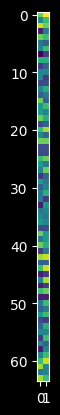

In [167]:
plt.imshow(channel2[100])

In [156]:
wParamsStr

<IgorWave 'wParamsStr' at 0x246404c70d0>

In [458]:
wParamsStr.save("test.ibw")

TypeError: Unsupported dtype: <class 'numpy.object_'>

In [452]:
imaging.name

'wDataCh0'

# Load data (old method)

In [ ]:

class get_stack:
    # This class is used in the .smh+.smp to .tiff conversion process, 
    # as well as for constructing the trigger signal. 
    def __init__(self, file_path):
        print("Getting stack...")
        self.file_path = pathlib.Path(file_path)
        self.data_directory = self.file_path.parent
        # def change_dir(path_of_file):
        #     prev_path = pathlib.Path.cwd() #Make note of current (will be previous) working directory
        #     print("Making note of old path: {}".format(prev_path))
        #     data_path = pathlib.Path(r'{}'.format(path_of_file)) #Construct data path
        #     new_path = pathlib.Path(data_path).resolve().parent #Set directory to file location 
        #     print("Changing path to: {}".format(new_path))
        #     os.chdir(new_path)#Change directory
        #     print("Done")
        #     return prev_path
        # prev_path = change_dir(path_of_file = self.data_directory)
        print("Getting data from {}".format(self.file_path))
        self.filename = self.file_path.name
        print("Reading header...")
        ## This part of script provided by Andre Chagas 
        dicHeader = rsm.read_in_header(filePath = self.file_path.with_suffix('.smh'))#+".smh")
        print("Header read.")
        self.frameN = int(dicHeader["NumberOfFrames"])
        self.frameC = int(dicHeader["FrameCounter"])
        self.frameB = int(dicHeader["StimBufPerFr"]) #Buffer between stimuli (mirror back into place)
        self.frameH = int(dicHeader["FrameHeight"])
        self.frameW = int(dicHeader["FrameWidth"])
        print("Reading data...")
        channel_dict = rsm.read_in_data(filePath=self.file_path.with_suffix('.smp'), header=dicHeader,
                                  readChan1=True, readChan2=True, 
                                  readChan3=True, readChan4=True)
        print("Data retrieved.")
        print("Converting to serialised data...")
        #Convert data from serialized to frames
        self.channel1 = rsm.to_frame(channel_dict["chan1"], frameTotal=self.frameN, 
                      frameCounter=self.frameC, frameBuffer=self.frameB, 
                      frameHeight=self.frameH, frameWidth=self.frameW)

        self.channel2 = rsm.to_frame(channel_dict["chan2"], frameTotal=self.frameN, 
                      frameCounter=self.frameC, frameBuffer=self.frameB, 
                      frameHeight=self.frameH, frameWidth=self.frameW)
        # self.channels_interleved = np.empty((self.channel1.size + self.channel2.size,), dtype=self.channel1.dtype)
        print("Conversion complete.")
        """Use: https://numpy.org/doc/stable/reference/generated/numpy.dstack.html"""
        # os.chdir(prev_path) # Go back where we came from
        print("Reverting path.")

In [ ]:
test = get_stack(r"C:\Users\Simen\Downloads\0_0_ColorSWN_200_0.smp")

In [ ]:
plt.imshow(np.average(test.channel1[:, :, 33:-40], axis = 0))